In [1]:
# Dataset - https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

In [20]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from  sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics 

import pickle

In [2]:
# Load datasets
fake = pd.read_csv('archive/Fake.csv')
real = pd.read_csv('archive/True.csv')

In [3]:
fake.shape, real.shape

((23481, 4), (21417, 4))

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
# Adding label: Fake = 0, Real = 1
fake['label'] = 0
real['label'] = 1

In [7]:
# Merging datasets
df = pd.concat([fake, real], axis=0)
df = df.sample(frac=1).reset_index(drop=True)  # shuffling 

In [8]:
df.head()

,title,text,subject,date,label
0,UK police making urgent inquiries to find who ...,LONDON (Reuters) - London police said on Frida...,worldnews,"September 15, 2017",1
1,Betsy DeVos TOTALLY HUMILIATED During Keynote...,U.S. Secretary of Education Betsy DeVos tried ...,News,"May 10, 2017",0
2,NZ First leader welcomes politically driven dr...,WELLINGTON (Reuters) - The leader of the small...,worldnews,"October 10, 2017",1
3,Trump Just Sent A MAJOR F*ck You To The Supre...,Donald Trump and his administration have prove...,News,"April 25, 2017",0
4,Trump says latest Obamacare repeal plan has 'v...,NEW YORK (Reuters) - President Donald Trump sa...,politicsNews,"September 20, 2017",1


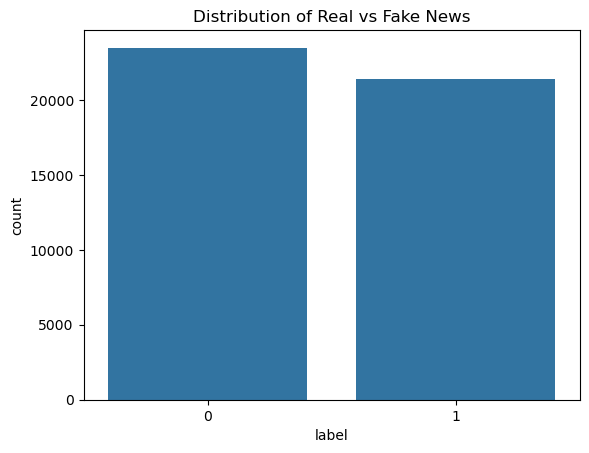

In [9]:
sns.countplot(x='label', data=df)
plt.title("Distribution of Real vs Fake News")
plt.show()

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[.*?]', '', text)  # remove text in square brackets
    text = re.sub('\\W', ' ', text)     # remove special characters
    text = re.sub('https?://\\S+|www\\.\\S+', '', text)  # remove links
    text = re.sub('<.*?>+', '', text)   # remove html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\\w*\\d\\w*', '', text)
    return text

In [11]:
df['content'] = df['title'] + ' ' + df['text']
df['content'] = df['content'].apply(preprocess_text)

In [12]:
df.head()

,title,text,subject,date,label,content
0,UK police making urgent inquiries to find who ...,LONDON (Reuters) - London police said on Frida...,worldnews,"September 15, 2017",1,uk police making urgent inquiries to find who ...
1,Betsy DeVos TOTALLY HUMILIATED During Keynote...,U.S. Secretary of Education Betsy DeVos tried ...,News,"May 10, 2017",0,betsy devos totally humiliated during keynote...
2,NZ First leader welcomes politically driven dr...,WELLINGTON (Reuters) - The leader of the small...,worldnews,"October 10, 2017",1,nz first leader welcomes politically driven dr...
3,Trump Just Sent A MAJOR F*ck You To The Supre...,Donald Trump and his administration have prove...,News,"April 25, 2017",0,trump just sent a major fck you to the suprem...
4,Trump says latest Obamacare repeal plan has 'v...,NEW YORK (Reuters) - President Donald Trump sa...,politicsNews,"September 20, 2017",1,trump says latest obamacare repeal plan has v...


In [13]:
X = df['content']
y = df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2), (2,3)],  # Unigrams, bigrams, char-level ngrams
    'vectorizer__analyzer': ['char', 'word'],
    'vectorizer__max_df': [0.7, 0.9]  # Ignore overly common words
}
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [47]:
# tfid_vector = TfidfVectorizer(stop_words='english')
pipeline = Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('model', LogisticRegression())])
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

In [50]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1); total time=  30.2s
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1); total time=  29.7s
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1); total time=  28.5s
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1); total time=  29.1s
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 1); total time=  28.3s
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2); total time= 1.4min
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2); total time= 1.4min
[CV] END vectorizer__analyzer=char, vectorizer__max_df=0.7, vectorizer__ngram_range=(1, 2); total time= 1.4min
[CV] END vectorizer__analyzer=char, vectorizer__max

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             param_grid={'vectorizer__analyzer': ['char', 'word'],
                         'vectorizer__max_df': [0.7, 0.9],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 3)]},
             scoring='accuracy', verbose=2)

In [59]:
# Print best parameters and accuracy
print(f"Best Parameters: {model.best_params_}")
print(f"Best Accuracy: {model.best_score_:.4f}")
best_model = model.best_estimator_
best_model

Best Parameters: {'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.9, 'vectorizer__ngram_range': (1, 1)}
Best Accuracy: 0.9866


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.9)),
                ('model', LogisticRegression())])

In [71]:
# pickle.dump(best_model, open("fake_news_detection.pkl", "wb"))

In [15]:
# best_model = pickle.load(open("fake_news_detection.pkl", "rb"))

In [16]:
y_pred = best_model.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)*100

99.12026726057907

In [18]:
# best_model.predict([df['content'][0]])[0]

1

In [22]:
metrics.confusion_matrix(y_test, y_pred)

array([[4607,   50],
       [  29, 4294]], dtype=int64)